In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from wordcloud import WordCloud
import re

In [8]:
# -------------------------------
# 1️⃣ Load datasets & label source
# -------------------------------

syn_train = pd.read_csv("train-test datasets//synthetic_train.csv")
syn_test = pd.read_csv("train-test datasets//synthetic_test.csv")
real_train = pd.read_csv("train-test datasets//yelp_sample_train.csv")
real_test = pd.read_csv("train-test datasets//yelp_sample_test.csv")

for df, name in zip([syn_train, syn_test, real_train, real_test],
                    ['syn_train','syn_test','real_train','real_test']):
    df['source'] = name

# Train-only dataset for safe EDA
train = pd.concat([syn_train, real_train], ignore_index=True)

In [9]:
# -------------------------------
# 2️⃣ Basic info
# -------------------------------
print("Train dataset info:")
display(train.info())
display(train.describe(include='object'))


Train dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2685 entries, 0 to 2684
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   dish_name    2685 non-null   object
 1   description  2442 non-null   object
 2   cuisine      2685 non-null   object
 3   diet         2685 non-null   object
 4   source       2685 non-null   object
dtypes: object(5)
memory usage: 105.0+ KB


None

,dish_name,description,cuisine,diet,source
count,2685,2442,2685,2685,2685
unique,2598,2435,12,2,2
top,Vegetable Curry,w. White Rice,Thai,Vegetarian,syn_train
freq,6,3,329,1443,1794


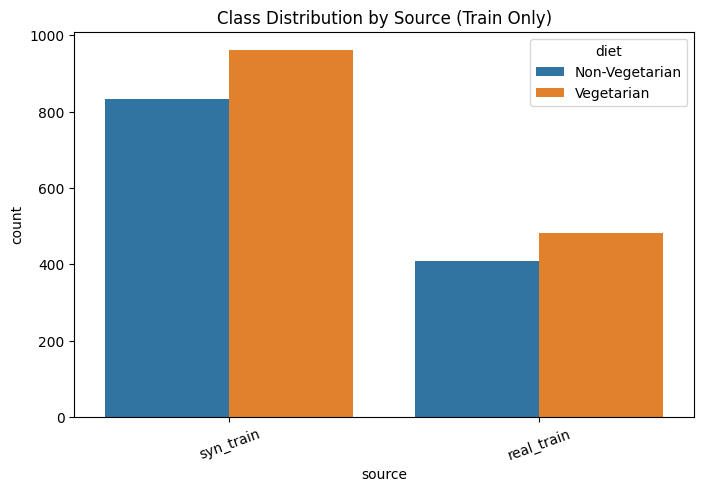

In [10]:
# -------------------------------
# 3️⃣ Class distribution (train)
# -------------------------------
plt.figure(figsize=(8,5))
sns.countplot(data=train, x='source', hue='diet')
plt.title('Class Distribution by Source (Train Only)')
plt.xticks(rotation=20)
plt.show()

C:\Users\Hatice\AppData\Local\Temp\ipykernel_3592\557537310.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='diet', y='desc_length', data=train, palette='Set2')


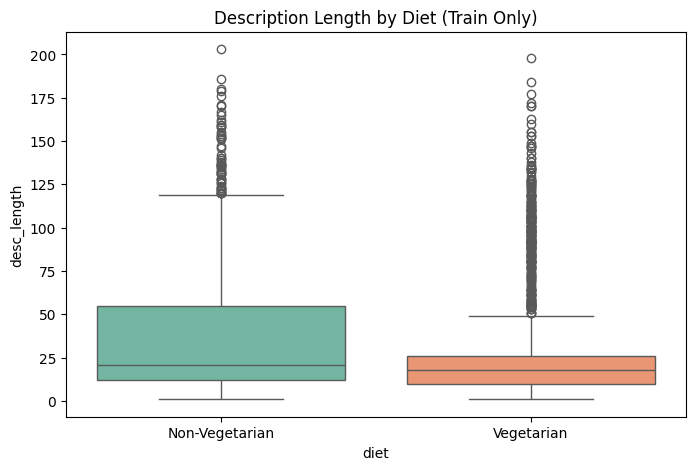

title_length                                                \
                      count      mean       std  min  25%  50%  75%   max   
diet                                                                        
Non-Vegetarian       1242.0  4.230274  2.218910  1.0  3.0  4.0  5.0  13.0   
Vegetarian           1443.0  4.184338  2.372836  1.0  2.0  4.0  5.0  15.0   

               desc_length                                                      
                     count       mean        std  min   25%   50%   75%    max  
diet                                                                            
Non-Vegetarian      1242.0  37.169082  37.864899  1.0  12.0  21.0  55.0  203.0  
Vegetarian          1443.0  28.931393  34.208792  1.0  10.0  18.0  26.0  198.0

In [11]:
# -------------------------------
# 4️⃣ Text length features
# -------------------------------
train['title_length'] = train['dish_name'].apply(lambda x: len(str(x).split()))
train['desc_length'] = train['description'].apply(lambda x: len(str(x).split()))

# Boxplots for description length
plt.figure(figsize=(8,5))
sns.boxplot(x='diet', y='desc_length', data=train, palette='Set2')
plt.title('Description Length by Diet (Train Only)')
plt.show()

# Text length statistics
display(train.groupby('diet')[['title_length','desc_length']].describe())

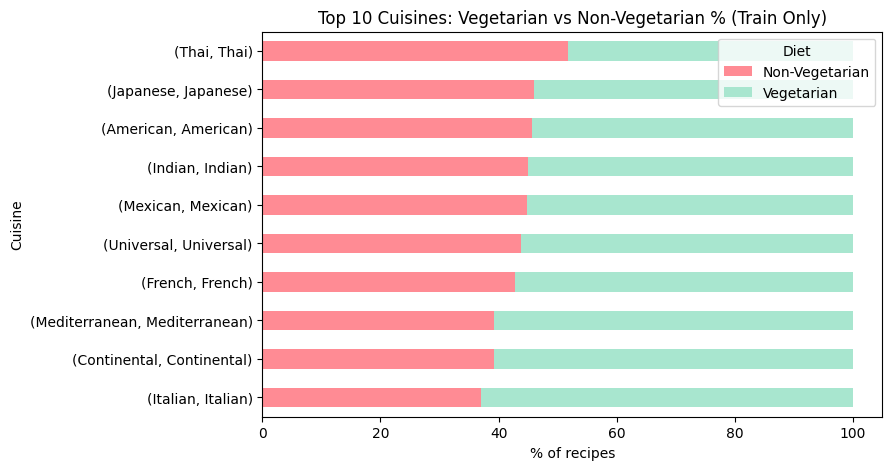

In [12]:
# -------------------------------
# 5️⃣ Cuisine-Diet relationship
# -------------------------------
cuisine_counts = (train.groupby(['cuisine', 'diet'])
                    .size()
                    .groupby(level=0)
                    .apply(lambda x: 100 * x / x.sum())
                    .unstack()
                    .fillna(0)
                    .sort_values('Vegetarian', ascending=False)
                    .head(10))

cuisine_counts.plot(kind='barh', stacked=True, figsize=(8,5), color=['#FF8B94','#A8E6CF'])
plt.xlabel('% of recipes')
plt.ylabel('Cuisine')
plt.title('Top 10 Cuisines: Vegetarian vs Non-Vegetarian % (Train Only)')
plt.legend(title='Diet')
plt.show()

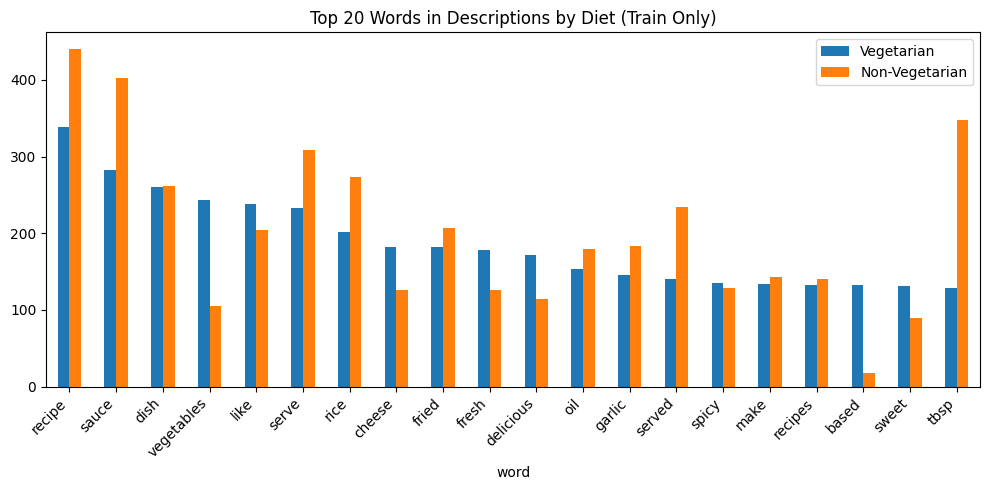

In [13]:
# -------------------------------
# 6️⃣ Word-level analysis (train only)
# -------------------------------
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X_train = vectorizer.fit_transform(train['description'].fillna(''))
words = vectorizer.get_feature_names_out()

veg_mask = (train['diet']=='Vegetarian').values
veg_counts = X_train[veg_mask].sum(axis=0).A1
nonveg_counts = X_train[~veg_mask].sum(axis=0).A1

freq_df = pd.DataFrame({
    'word': words,
    'Vegetarian': veg_counts,
    'Non-Vegetarian': nonveg_counts
}).sort_values(by='Vegetarian', ascending=False)

# Top 20 words
freq_df.head(20).plot(x='word', y=['Vegetarian','Non-Vegetarian'], kind='bar', figsize=(10,5))
plt.title('Top 20 Words in Descriptions by Diet (Train Only)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

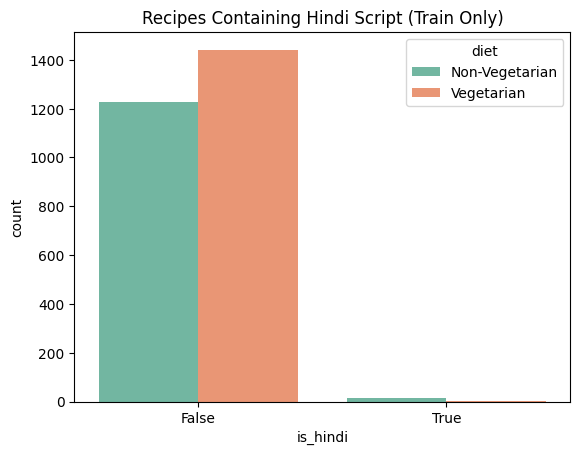

In [14]:
# -------------------------------
# 7️⃣ Language check (Hindi script)
# -------------------------------
train['is_hindi'] = train['description'].apply(lambda x: bool(re.search(r'[\u0900-\u097F]', str(x))))
sns.countplot(x='is_hindi', hue='diet', data=train, palette='Set2')
plt.title('Recipes Containing Hindi Script (Train Only)')
plt.show()

In [15]:
# -------------------------------
# 8️⃣ Duplicate check
# -------------------------------
dup = train[train.duplicated(['dish_name','description'], keep=False)]
print(f"Duplicate rows in train: {len(dup)}")
if len(dup)>0:
    display(dup.groupby('dish_name').size().head(10))

Duplicate rows in train: 2


dish_name
Pad Thai    2
dtype: int64

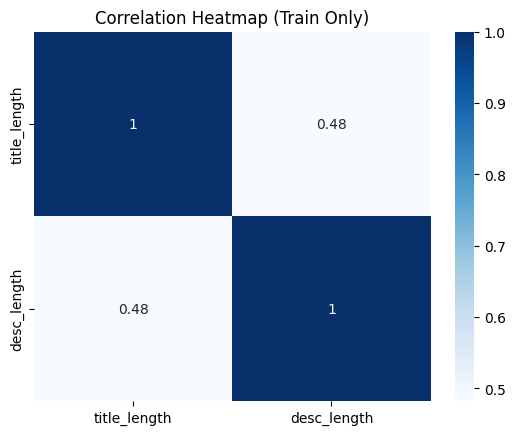

In [16]:
# -------------------------------
# 9️⃣ Feature correlations
# -------------------------------
sns.heatmap(train[['title_length','desc_length']].corr(), annot=True, cmap='Blues')
plt.title('Correlation Heatmap (Train Only)')
plt.show()

C:\Users\Hatice\AppData\Local\Temp\ipykernel_3592\4193885009.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='diet', y='sentiment', data=train, palette='Set2')


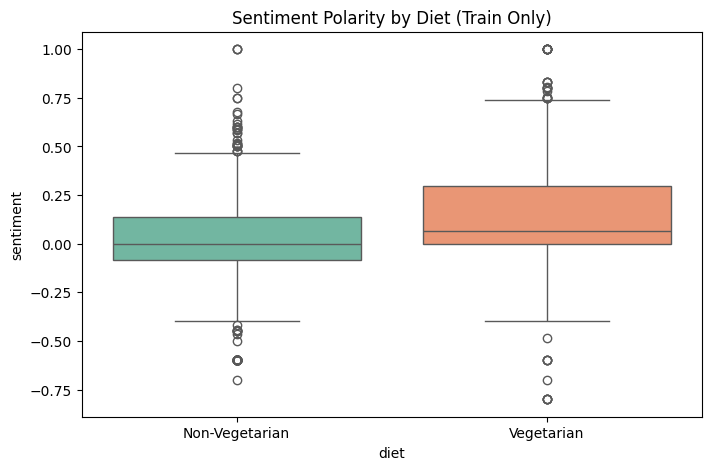

In [17]:

# -------------------------------
# 🔟 Sentiment analysis
# -------------------------------
train['sentiment'] = train['description'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
plt.figure(figsize=(8,5))
sns.boxplot(x='diet', y='sentiment', data=train, palette='Set2')
plt.title('Sentiment Polarity by Diet (Train Only)')
plt.show()

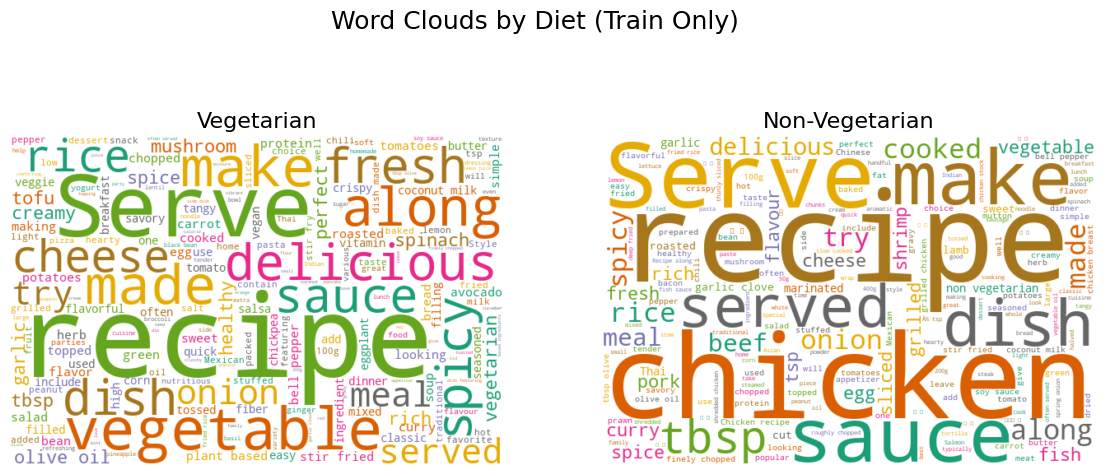

In [19]:
# -------------------------------
# 11️⃣ Word clouds (train only) - Fixed
# -------------------------------
fig, axes = plt.subplots(1,2, figsize=(14,6))

for ax, label, color in zip(axes, ['Vegetarian','Non-Vegetarian'], ['#A8E6CF','#FF8B94']):
    # Convert to string and drop NaN
    text_series = train[train['diet']==label]['description'].dropna().astype(str)
    text = " ".join(text_series)
    
    wc = WordCloud(width=600, height=400, background_color='white', colormap='Dark2').generate(text)
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(label, fontsize=16)

plt.suptitle("Word Clouds by Diet (Train Only)", fontsize=18)
plt.show()
